In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import corner
import os
import sys
import glob
import seaborn as sns
from copy import deepcopy
from astropy.io import fits
from scipy import stats

PROJECT_DIR = '/Users/research/projects/kepler-ecc-rp/'

sys.path.append(PROJECT_DIR)
from utils.stats import weighted_percentile
from utils.io import load_posteriors, extract_posteriors

pi = np.pi

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


## Load data

In [2]:
PATH = os.path.join(PROJECT_DIR, 'Results/20240526/prior-test/')
files = list(np.sort(glob.glob(os.path.join(PATH, '*.fits'))))

samples, headers, bin_edges = load_posteriors(files)
rp, ecc, mult, nobj = extract_posteriors(samples, headers)

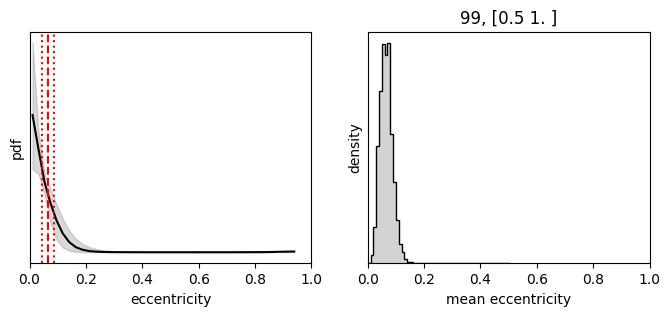

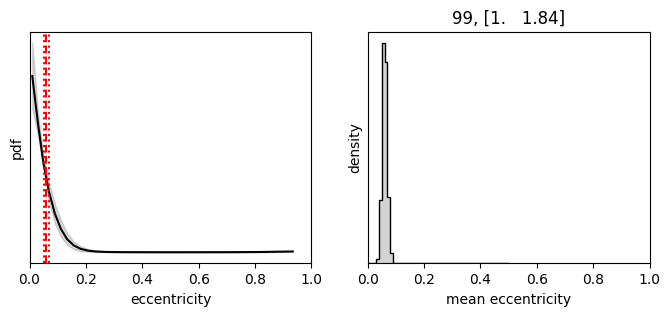

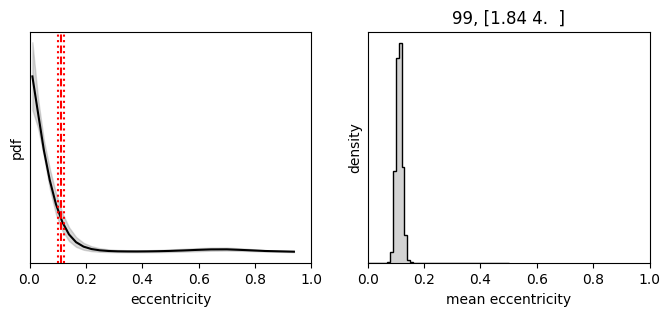

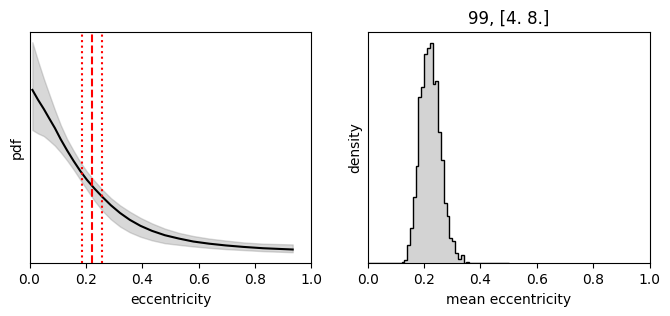

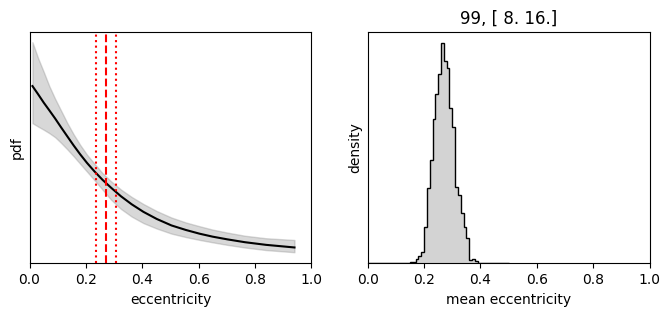

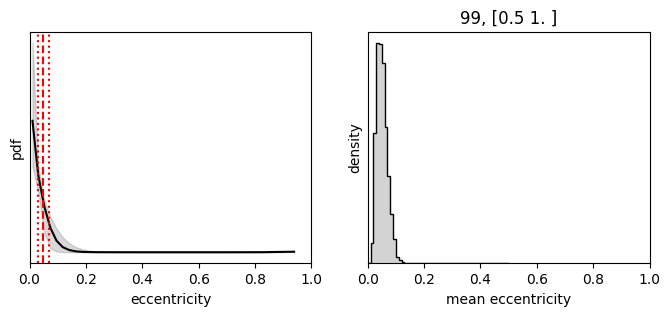

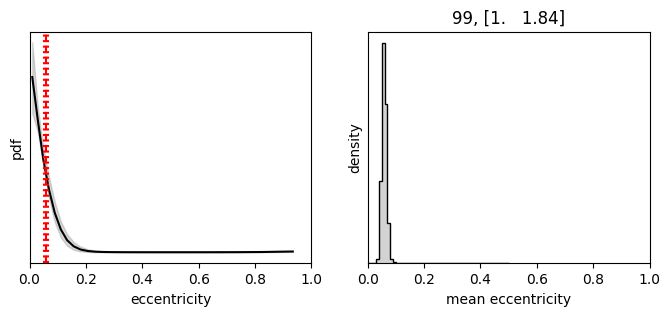

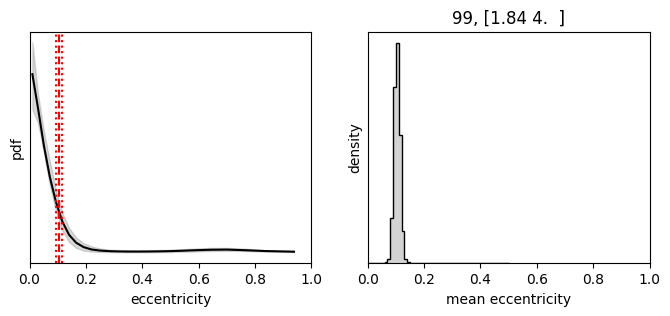

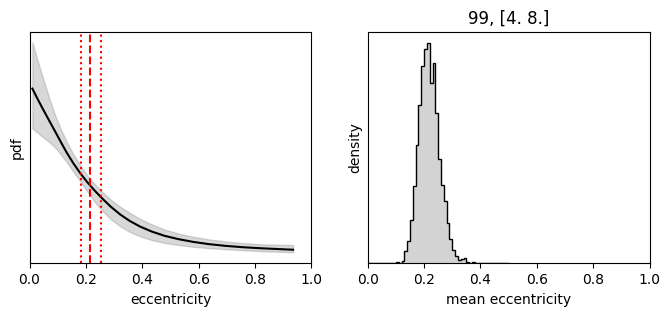

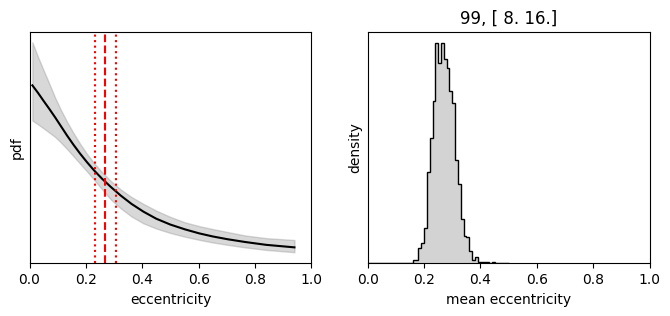

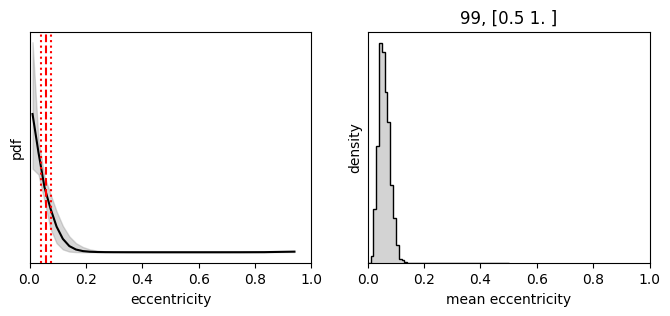

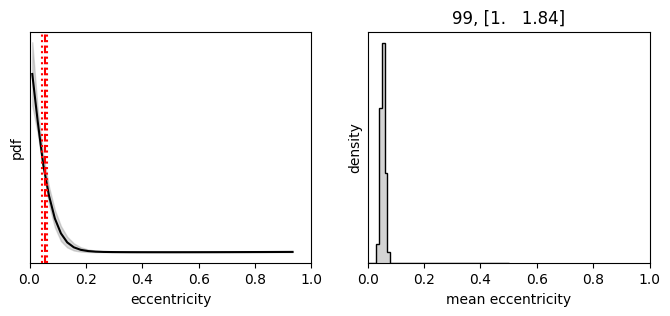

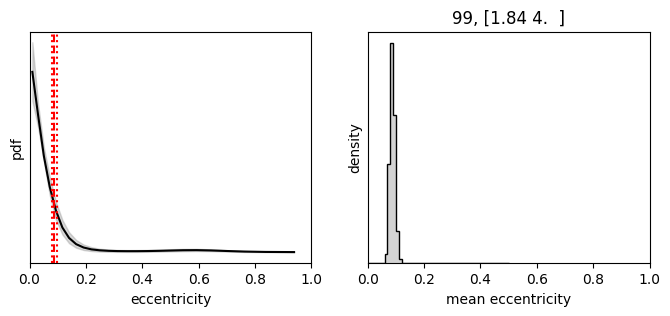

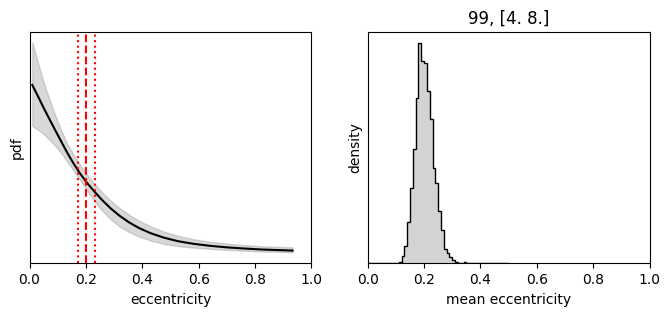

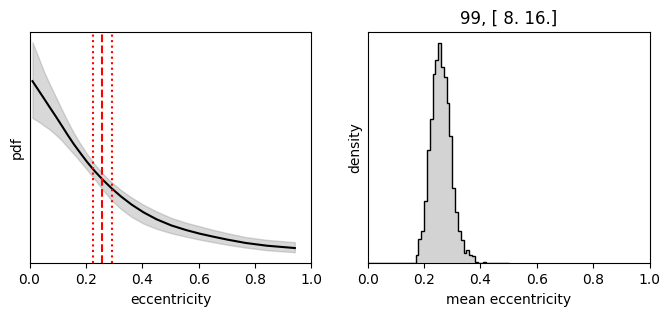

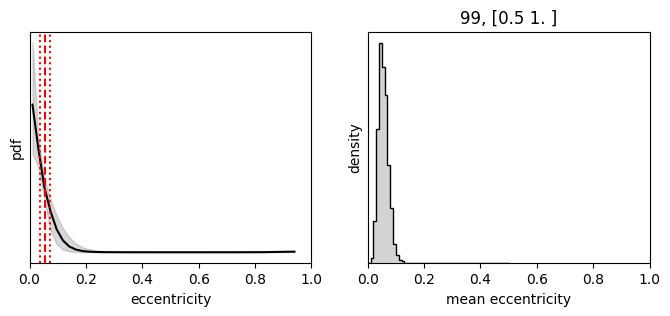

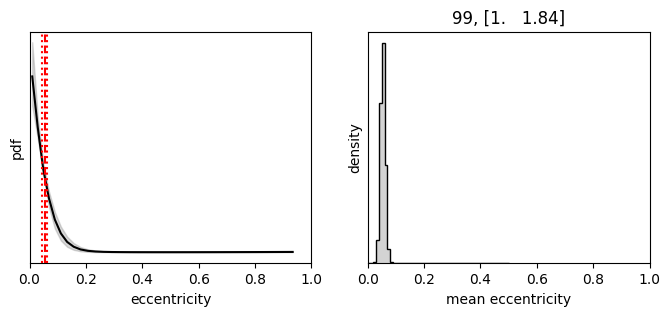

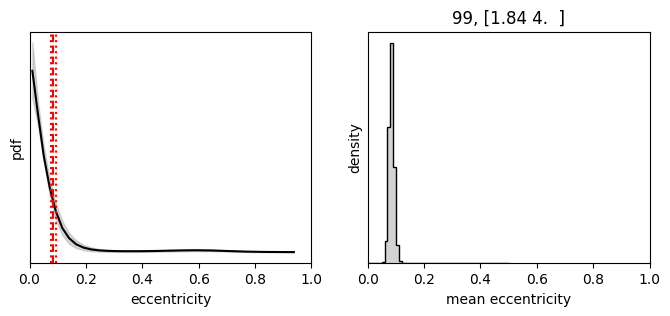

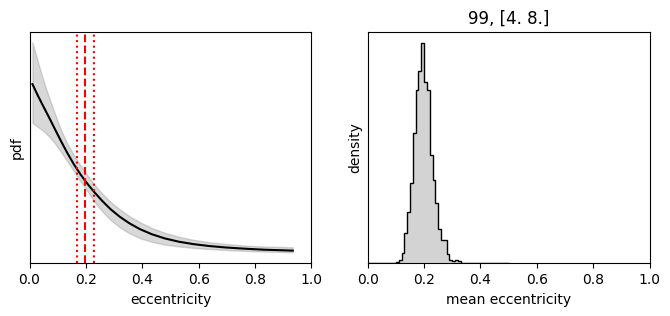

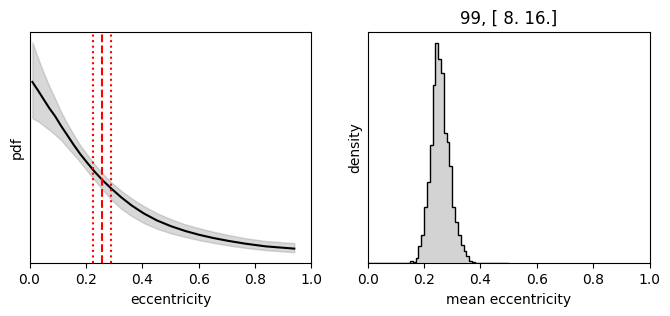

In [3]:
for i, s in enumerate(samples):
    bin_centers = 0.5*(bin_edges[i][1:] + bin_edges[i][:-1])
    
    ln_pdf = s.filter(regex='ln_pdf')
    ln_pdf = ln_pdf.reindex(sorted(ln_pdf.columns), axis=1)

    pdf = np.exp(np.percentile(ln_pdf, [16,50,84], axis=0))
    mu = np.percentile(ecc[i], [16,50,84])

    fig, ax = plt.subplots(1,2, figsize=(8,3))
    
    ax[0].plot(bin_centers, pdf[1], c='k')
    ax[0].fill_between(bin_centers, pdf[0], pdf[2], color='grey', alpha=0.3)
    ax[0].axvline(mu[0], color='r', ls=':')
    ax[0].axvline(mu[1], color='r', ls='--')
    ax[0].axvline(mu[2], color='r', ls=':')
    ax[0].set_xlim(0,1)
    ax[0].set_yticks([])
    ax[0].set_xlabel("eccentricity")
    ax[0].set_ylabel("pdf")
    
    ax[1].hist(ecc[i], color='lightgrey', bins=np.linspace(0,0.5,51))
    ax[1].hist(ecc[i], color='k', histtype='step', bins=np.linspace(0,0.5,51))
    ax[1].set_xlim(0,1)
    ax[1].set_yticks([])
    ax[1].set_xlabel("mean eccentricity")
    ax[1].set_ylabel("density")

    plt.title("{0}, {1}".format(mult[i], rp[i]))
    plt.show()

## Overplot priors

In [18]:
def find_first_local_min_arg(y):
    n = len(y)
    for j in range(1,n-1):
        if (y[j] < y[j-1])*(y[j] < y[j+1]):
            return j

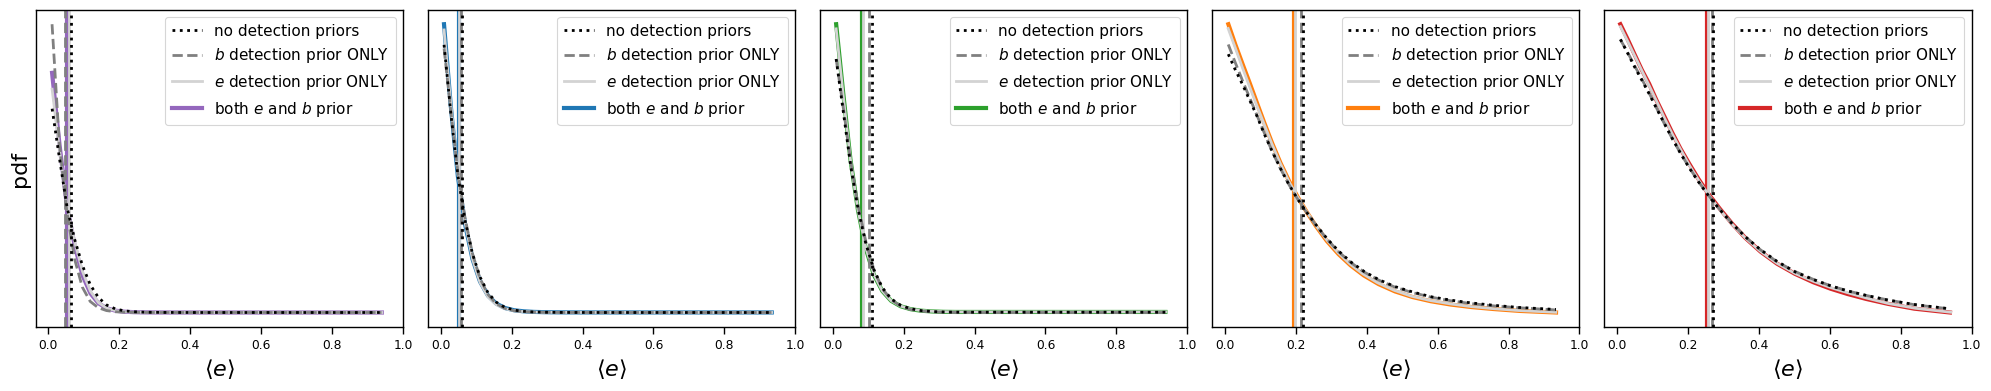

In [23]:
sns.set_context('paper')
colors = ['C4', 'C0', 'C2', 'C1', 'C3']

fig, ax = plt.subplots(1,5, figsize=(20,4))

for i, s in enumerate(samples):
    # extract data
    head = headers[i]
    bin_centers = 0.5*(bin_edges[i][1:] + bin_edges[i][:-1])
    
    ln_pdf = s.filter(regex='ln_pdf')
    ln_pdf = ln_pdf.reindex(sorted(ln_pdf.columns), axis=1)

    pdf = np.exp(np.percentile(ln_pdf, 50, axis=0))    
    mu = np.percentile(ecc[i], 50)

    # enforce monotonicity on pdf
    loc = find_first_local_min_arg(pdf)
    pdf[loc:] = pdf[loc]

    # determine index of planet size class
    if head['RAD_0'] == 0.5:
        j = 0
    if head['RAD_0'] == 1.0:
        j = 1
    if head['RAD_0'] == 1.84:
        j = 2
    if head['RAD_0'] == 4.0:
        j = 3
    if head['RAD_0'] == 8.0:
        j = 4

    # determine which prior settings were used
    if head['E_PRIOR'] and head['B_PRIOR']:
        label = 'both $e$ and $b$ prior'
        color = colors[j]
        ls = '-'
        lw = 3
        zorder = 0
    if head['E_PRIOR'] and not(head['B_PRIOR']):
        label = '$e$ detection prior ONLY'
        color = 'lightgrey'
        ls = '-'
        lw = 2
        zorder = 1
    if not(head['E_PRIOR']) and head['B_PRIOR']:
        label = '$b$ detection prior ONLY'
        color = 'grey'
        ls = '--'
        lw = 2
        zorder = 2
    if not(head['E_PRIOR']) and not(head['B_PRIOR']):
        label = 'no detection priors'
        color = 'k'
        ls = ':'
        lw = 2
        zorder = 3
        
    ax[j].plot(bin_centers, pdf, label=label, color=color, ls=ls, lw=lw, zorder=zorder)
    ax[j].axvline(mu, color=color, ls=ls, lw=lw, zorder=zorder)
    ax[j].set_xlabel(r'$\langle e \rangle$', fontsize=16)
    ax[j].set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax[j].set_yticks([])
    ax[j].legend(fontsize=11)

ax[0].set_ylabel('pdf', fontsize=16)
plt.tight_layout()
plt.show()